# Data analysis

In [1]:
import os
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
#mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')
gdrive_path = "/content/drive/MyDrive/Tidy_Python_2025/"
%cd $gdrive_path

Mounted at /content/drive
/content/drive/MyDrive/Tidy_Python_2025


In [3]:
data_tidy_path = gdrive_path + 'data_tidy_path/'

In [4]:
crabs = pd.read_parquet(os.path.join(data_tidy_path, 'crabs.parquet'))

In [5]:
crabs.head()

,region,date,species,sex,stage,is_gravid,carapace_width,carapace_length,front_width,left_claw_length,right_claw_length,depth [m],associated_species,behaviour
0,Ria Formosa,2022-07-29,Afruca farensis,female,juvenile,True,0.926986,0.771916,2.5,1.378614,0.812367,6.0,"['Snail', 'Jellyfish', 'Algae', 'Sea Star', 'S...",Hiding under seagrass blades.
1,Ria Formosa,2022-07-29,Uca olhanensis,male,sub_adult,None,6.057396,5.875000,2.5,8.044241,6.441028,8.0,"['Sea Sponge', 'Shrimp', 'Coral Fragment', 'Se...",Crab moving quickly across rocks.
2,Ria Formosa,2022-07-29,Uca olhanensis,female,adult,True,4.098023,3.474046,2.3,6.086304,3.521620,8.0,"['Crab (Other Species)', 'Coral Fragment']",Camouflaging with surrounding mud.
3,Ria Formosa,2022-07-29,Afruca farensis,female,pre_puberty,True,1.646883,2.181484,2.5,2.139543,2.210658,6.0,"['Sea Star', 'Jellyfish']",Vibrating antennae in water currents.
4,Ria Formosa,2022-07-29,Afruca farensis,NaN,sub_adult,None,3.666775,3.750000,2.3,4.626508,3.957380,6.0,['Hermit Crab'],Territorial display against intruder.


In [6]:
crabs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22081 entries, 0 to 22080
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   region              22081 non-null  category      
 1   date                22081 non-null  datetime64[ns]
 2   species             22081 non-null  category      
 3   sex                 20225 non-null  category      
 4   stage               22081 non-null  category      
 5   is_gravid           11191 non-null  object        
 6   carapace_width      22081 non-null  float64       
 7   carapace_length     22081 non-null  float64       
 8   front_width         22081 non-null  float64       
 9   left_claw_length    22081 non-null  float64       
 10  right_claw_length   22081 non-null  float64       
 11  depth [m]           22081 non-null  float64       
 12  associated_species  22081 non-null  object        
 13  behaviour           22081 non-null  object    

Analysis todo
- clustering of behaviours
- predict stage from the measures
    - select predictive features


## Statistical methods
- `scipy`
- `statsmodels`
- `scikit-learn`, ie `sklearn`

### Principal Component Analysis (PCA)

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [12]:
numeric_cols = [
    'carapace_width',
    'carapace_length',
    'front_width',
    'left_claw_length',
    'right_claw_length',
    'depth [m]'
]

In [26]:
# Drop rows with NaNs in numeric + label column (e.g., 'species')
df_pca = crabs.dropna(subset=numeric_cols + ['species', 'region'])

# Standardize the numeric features
X_scaled = StandardScaler().fit_transform(df_pca[numeric_cols])

In [28]:
#@title Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [29]:
# Create PCA DataFrame and add back species info
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['species'] = df_pca['species'].reset_index(drop=True)
pca_df['region'] = df_pca['region'].reset_index(drop=True)
pca_df.head()

,PC1,PC2,species,region
0,-1.765251,-1.193398,Afruca farensis,Ria Formosa
1,4.399392,0.341883,Uca olhanensis,Ria Formosa
2,1.845254,-0.127925,Uca olhanensis,Ria Formosa
3,-0.546504,-1.034019,Afruca farensis,Ria Formosa
4,1.631614,-0.883933,Afruca farensis,Ria Formosa


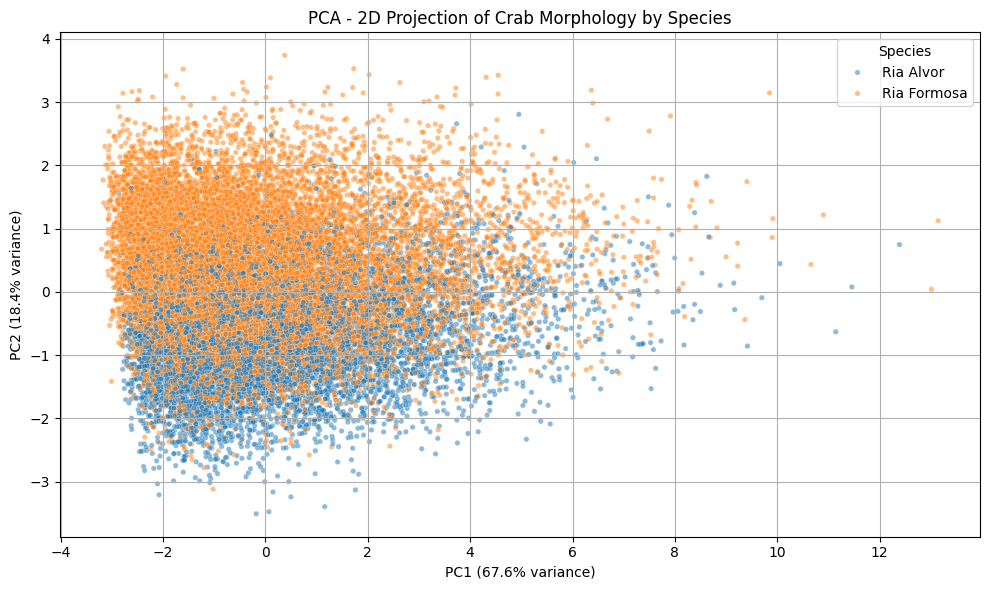

In [35]:
#@title Plot PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='region', alpha=0.5, s=15)
plt.title('PCA - 2D Projection of Crab Morphology by Species')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.legend(title='Species')
plt.grid(True)
plt.tight_layout()
plt.show()

### ANOVA

In [34]:
# Drop missing values (sex has NaNs)
df_anova = crabs[['carapace_width', 'sex']].dropna()

# Fit the model
model = smf.ols('carapace_width ~ C(sex)', data=df_anova).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(sex),1127.288866,1.0,430.032375,1.539556e-94
Residual,53012.666195,20223.0,NaN,NaN


`sum_sq` (Sum of Squares):
- 1127.29 of the variation in carapace_width is explained by sex.
- 53012.67 is unexplained (random noise, individual variation).

`df` (Degrees of Freedom):
- 1 for sex (only two groups: male and female).
- 20223 for the residual (number of observations - number of groups).

F (F-statistic):
- 430.03 → This is very large, meaning the between-group variability is far greater than within-group variability.

`PR(>F)` (p-value):
- 1.54e-94 → Extremely small, meaning the difference in means is statistically significant.

## Time series

In [36]:
crabs['species'].value_counts()

,count
species,
Uca olhanensis,12045
Afruca farensis,8181
Ucides alvorensis,1855


In [51]:
uca_counts = crabs.groupby(['species', 'date', 'region']).size()

/tmp/ipython-input-51-1222202361.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  uca_counts = crabs.groupby(['species', 'date', 'region']).size()


In [57]:
time_series = uca_counts.unstack(level=0).unstack(level=1)

In [58]:
time_series.columns

MultiIndex([(  'Afruca farensis',   'Ria Alvor'),
            (  'Afruca farensis', 'Ria Formosa'),
            (   'Uca olhanensis',   'Ria Alvor'),
            (   'Uca olhanensis', 'Ria Formosa'),
            ('Ucides alvorensis',   'Ria Alvor'),
            ('Ucides alvorensis', 'Ria Formosa')],
           names=['species', 'region'])

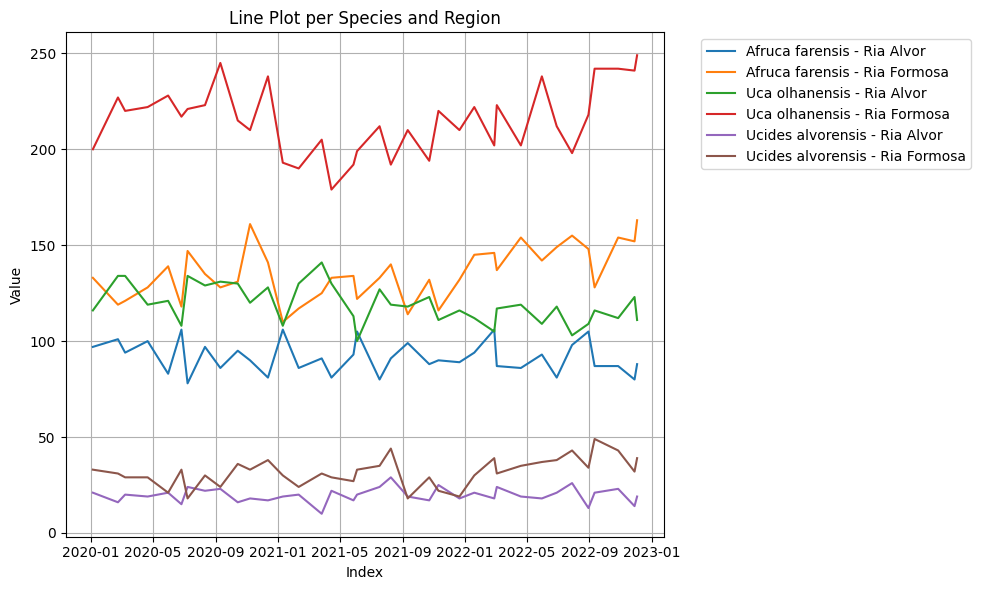

In [59]:
# Assume df_lines.columns is a MultiIndex with ('species', 'region')
fig, ax = plt.subplots(figsize=(10, 6))

for col in time_series.columns:
    species, region = col
    ax.plot(time_series.index, time_series[col], label=f"{species} - {region}")

ax.set_xlabel("Index")  # or use e.g. 'Date' if your index is time
ax.set_ylabel("Value")
ax.set_title("Line Plot per Species and Region")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

/tmp/ipython-input-64-4193404581.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time_series_resampled = time_series.resample('M').mean()


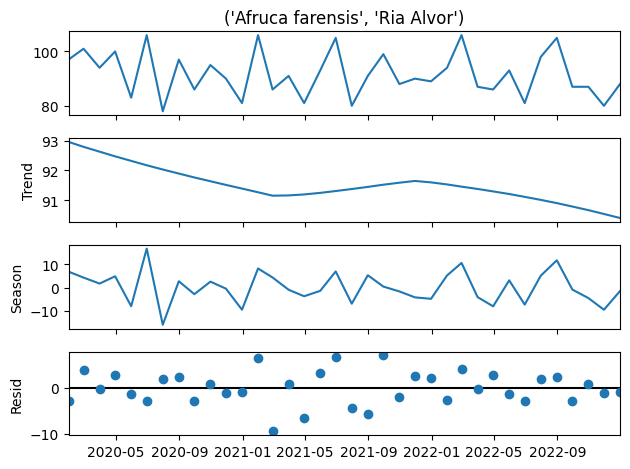

In [64]:
from statsmodels.tsa.seasonal import STL

# Resample the time series to a monthly frequency
time_series_resampled = time_series.resample('M').mean()

# Apply STL decomposition to the resampled time series
# Choose a seasonal period appropriate for your data (e.g., 12 for monthly data)
# You might need to adjust the seasonal period based on your domain knowledge or by inspecting the data
stl = STL(time_series_resampled['Afruca farensis', 'Ria Alvor'], seasonal=5) # Assuming a yearly seasonality with 12 months
res = stl.fit()
fig = res.plot()
plt.show()

## Cluster Behaviours


## Predictive models

In [ ]:
# for example